## Initial setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)
import torch
print(torch.__version__)
import matplotlib
print(matplotlib.__version__)

2.8.2
1.12.1+cu113
3.2.2


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [34]:
# Other imports
! pip install tensorflow_addons
! pip install tensorflow_io

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import sklearn.manifold
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, confusion_matrix, r2_score
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from IPython.display import Image, display


import zipfile
import concurrent.futures

# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset gathering and preparation

In [5]:
%cd /content/drive/MyDrive/nanowire-morphology-classification-project

/content/drive/MyDrive/nanowire-morphology-classification-project


In [6]:
training_batch_size = 4

BATCH_SIZE = training_batch_size

imageSize = 224

category_names = ['bundle', 'dispersed', 'network', 'singular']
color_method = ['C0', 'C1', 'C2', 'C3', 'C4']
color = ['black', 'magenta', 'cyan', 'yellow']
marker = ['o', 's', '<', '>', '^']
seaborn_palette = sns.color_palette("colorblind")

In [7]:
np.random.seed(random_seed)
peptide_morph_train_path = "/content/drive/MyDrive/TEM image datasets/2022-nanowire-morphology"
peptide_morph_images_train = list(paths.list_files(basePath=peptide_morph_train_path, validExts='jpg'))
peptide_morph_images_train = np.random.choice(np.array(peptide_morph_images_train), len(peptide_morph_images_train), replace=False)
print(len(peptide_morph_images_train))

400


In [8]:
train_labels = []
for i in range(peptide_morph_images_train.shape[0]):
  train_label = peptide_morph_images_train[i].split("/")[-2]
  train_labels.append(train_label)
le = LabelEncoder()
peptide_morph_train_enc = le.fit_transform(train_labels)

In [9]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    # image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[imageSize, imageSize])

    return image

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(peptide_morph_images_train)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # .shuffle(200)
    .batch(training_batch_size
          #  , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

datagen = tf. keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [11]:
np.random.seed(random_seed)
peptide_morph_seglabel_train_path = "/content/drive/MyDrive/TEM image datasets/2022-nanowire-morphology"
peptide_morph_images_train_seglabel = list(paths.list_files(basePath=peptide_morph_seglabel_train_path, validExts='png'))
peptide_morph_images_train_seglabel = np.random.choice(np.array(peptide_morph_images_train_seglabel), len(peptide_morph_images_train_seglabel), replace=False)
print(len(peptide_morph_images_train_seglabel))

200


In [12]:
def generate_ground_truth_images(image, resolution):
  image_bool = np.ones((resolution, resolution))
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if image[i, j, 1] == image[i, j, 2]:
        image_bool[i, j] = 0            # background is black with code of 0
      else: 
        image_bool[i, j] = 1            # nanowire is white with code of 1
  return image_bool

In [13]:
segmentation_class_labels = []
for i in range(peptide_morph_images_train_seglabel.shape[0]):
  seg_class_label = peptide_morph_images_train_seglabel[i].split("/")[-2]
  segmentation_class_labels.append(seg_class_label)
le = LabelEncoder()
peptide_morph_train_seg_enc = le.fit_transform(segmentation_class_labels)

In [14]:
# image_mask = np.zeros((len(peptide_morph_images_train_seglabel), imageSize, imageSize))
images_no_annotation_directory = []
images_no_annotation = np.zeros((len(peptide_morph_images_train_seglabel), imageSize, imageSize, 3))

for i in range(len(peptide_morph_images_train_seglabel)):
  images_no_annotation_directory.append('%s.jpg' % (peptide_morph_images_train_seglabel[i].split("_")[0] + "_" + peptide_morph_images_train_seglabel[i].split("_")[1]))
  images_no_annotation[i] = parse_images(images_no_annotation_directory[i])

  # these were used to create the ground truth grayscale images from the manual segmentation labels.
  # image_string = tf.io.read_file(peptide_morph_images_train_seglabel[i])
  # image = tf.image.decode_image(image_string, channels=3) / 255
  # image = tf.image.resize(image, (imageSize, imageSize))
  # image = tf.image.convert_image_dtype(image, tf.float32)
  # trans_nd_image_array = image.numpy()
  # image_mask[i] = generate_ground_truth_images(trans_nd_image_array, imageSize)
  
# np.savez_compressed('seg_mask_res512.npz', mask=image_mask)

# once we have the seg_mask saved, we can directly load from npz file
image_mask = np.load('seg_mask_res%i.npz' % (imageSize), allow_pickle=True)['mask']

## Initiate self-supervised models

In [15]:
Resnet50_transfer = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(imageSize, imageSize, 3), 
    pooling=None,
)

Resnet50_transfer.trainable = False

94781440/94765736 [==============================] - 2s 0us/step


In [16]:
# Resnet as backbone
def get_resnet_self_supervise_model(hidden_1, hidden_2, hidden_3):
    base_model = Resnet50_transfer
    base_model.trainable = True
    inputs = Input((imageSize, imageSize, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)                                        
    projection_1 = Activation("relu")(projection_1)
    projection_1 = BatchNormalization(epsilon=0.001)(projection_1)
    # projection_1 = Dropout(rate=0.5)(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_2 = BatchNormalization(epsilon=0.001)(projection_2)
    # projection_2 = Dropout(rate=0.5)(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)
    projection_3 = BatchNormalization(epsilon=0.001)(projection_3)
    # projection_3 = Dropout(rate=0.5)(projection_3)

    resnet_model = Model(inputs, projection_3)
    
    return resnet_model

## Initiate downstream classification model

In [17]:
def get_linear_model(features):                                                                                  
    linear_model = Sequential([                                                                                  
			                              Input(shape=(features,)),
		                                Dense(4, activation="softmax")])
    return linear_model

## One-shot learning and tsne visualizations


In [18]:
def visualize_scatter_with_images(X_2d_data, images_directory, true_label, ax, image_zoom=1, boxthickness=2):

    for xy, i, label in zip(X_2d_data, images_directory, true_label):
        x0, y0 = xy
        img = parse_images(i)
        img = OffsetImage(img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True,
                            bboxprops =dict(edgecolor=color[label], lw=boxthickness), pad=1)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)

In [19]:
def visualize_anchor_images(X_2d_data, images_directory, true_label, ax, image_zoom=1, boxthickness=2):

    for xy, i, label in zip(X_2d_data, images_directory, true_label):
        x0, y0 = xy
        img = parse_images(i)
        img = OffsetImage(img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True,
                            bboxprops =dict(edgecolor=color[label], lw=boxthickness), pad=0)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)

(-0.02, 0.52)

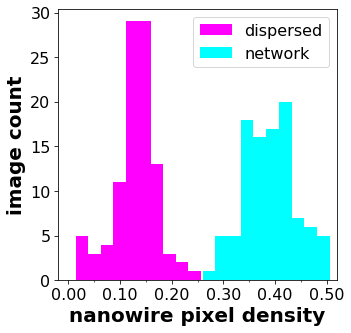

In [20]:
# calculate nanowire pixel density for each segmentation mask from the two morphologies
nanowire_pixel_density = np.zeros((image_mask.shape[0]))
for i in range(image_mask.shape[0]):
  nanowire_pixel_density[i] = np.sum(image_mask[i]) / imageSize / imageSize 
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(nanowire_pixel_density[np.where(peptide_morph_train_seg_enc == 0)], color=color[1], label='dispersed')
plt.hist(nanowire_pixel_density[np.where(peptide_morph_train_seg_enc == 1)], color=color[2], label='network')
plt.legend(fontsize=16)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'nanowire pixel density', fontsize=20, fontweight='bold')
ax.set_ylabel(r'image count', fontsize=20, fontweight='bold')
ax.xaxis.set_major_locator(MultipleLocator(0.10))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
ax.set_xlim(-0.02, 0.52)

In [ ]:
# this code block is for generating tsne plots and nanowire density plots only for the good and bad anchors for each five encoder.
# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.linspace(42, 42 + 19, 20).astype(int)

# list of models
models = ['barlow_tem']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

classification_result = {}
for i in range(len(models)):
  y = np.load('classify_scores_main_result/%s_classification_result.npz' % (models[i])
      , allow_pickle=True)
  classification_result.update({'%s' % (models[i]): y['scores']})

for i in range(len(random_seed_list)):

  seed_max = np.argmax(classification_result['%s' % (models[0])][-1][i], axis=0)[0]
  seed_min = np.argmin(classification_result['%s' % (models[0])][-1][i], axis=0)[0]
  seed_to_look = np.array([seed_max, seed_min])
  print(np.max(classification_result['%s' % (models[0])][-1][i], axis=0))
  print(np.min(classification_result['%s' % (models[0])][-1][i], axis=0))

  resnet_model = get_resnet_self_supervise_model(128, 64, 1024)
  resnet_model.load_weights('barlow_resnet_batch64_project128_64_1024_seed%i.h5' % (random_seed_list[i]))
  resnet_model.layers[1].trainable = False

  feature_extraction_model = Model(resnet_model.input, resnet_model.layers[-9].output)

  # Extract train and test features
  features = feature_extraction_model.predict(train_ds)
  
  for j in range(2):

    train_feature, test_feature, train_label, test_label = train_test_split(features, peptide_morph_train_enc, test_size=0.2, shuffle=True, stratify=peptide_morph_train_enc, random_state=random_seed_for_split[seed_to_look[j]])
    train_filename, test_filename, train_label, test_label = train_test_split(peptide_morph_images_train, peptide_morph_train_enc, test_size=0.2, shuffle=True, stratify=peptide_morph_train_enc, random_state=random_seed_for_split[seed_to_look[j]])      
    train_label_storage = pd.DataFrame(np.concatenate((train_filename.reshape(1, -1).transpose(), train_label.reshape(1, -1).transpose()), axis=-1), columns=['filename', 'label'])
    test_label_storage = pd.DataFrame(np.concatenate((test_filename.reshape(1, -1).transpose(), test_label.reshape(1, -1).transpose()), axis=-1), columns=['filename', 'label'])
    train_feature_map = train_feature[train_label_storage.groupby('label').sample(n=1, random_state = 42).index.to_numpy()]
    train_images_directory = train_label_storage.groupby('label').sample(n=1, random_state = 42)['filename'].to_numpy().astype(str)
    train_images_label = train_label_storage.groupby('label').sample(n=1, random_state = 42)['label'].to_numpy().astype(int)

    img1 = load_img(train_images_directory[0])
    img2 = load_img(train_images_directory[1])
    img3 = load_img(train_images_directory[2])
    img4 = load_img(train_images_directory[3])
    images_to_plot = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

    f, ax = plt.subplots(ncols=4, nrows=1, figsize=(10, 10))
    for m in range(4):
        ax[m].set_title(category_names[m], fontsize=14)
        ax[m].imshow(images_to_plot[m])
        ax[m].axis('off')
    plt.tight_layout()
    plt.show()

    # checking the nanowire_pixel_densities of the anchor and test images from dispersed and network morphologies
    dispersed_anchor_filename = train_images_directory[1].split(".")[0] + "_label.png"
    network_anchor_filename = train_images_directory[2].split(".")[0] + "_label.png"

    dispersed_anchor = nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==dispersed_anchor_filename)]
    network_anchor = nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==network_anchor_filename)]
    print(dispersed_anchor)
    print(network_anchor)

    dispersed_filenames = [test_filename[np.where(test_label==1)][i].split(".")[0] + "_label.png" for i in range(20)]
    dispersed_pixel_densities = np.array([nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==dispersed_filenames[i])] for i in range(20)]).reshape(-1)
    network_filenames = [test_filename[np.where(test_label==2)][i].split(".")[0] + "_label.png" for i in range(20)]
    network_pixel_densities = np.array([nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==network_filenames[i])] for i in range(20)]).reshape(-1)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.hist(dispersed_pixel_densities, color=color[1], label='dispersed')
    plt.hist(network_pixel_densities, color=color[2], label='network')
    plt.vlines(dispersed_anchor, 0, 4, colors='k', ls='solid')
    plt.vlines(np.median(dispersed_pixel_densities), 0, 4, colors='k', ls='--')
    plt.vlines(network_anchor, 0, 4, colors='k', ls='solid')
    plt.vlines(np.median(network_pixel_densities), 0, 4, colors='k', ls='--')
    plt.legend(fontsize=16)
    ax.tick_params(labelsize=16, length=4)
    ax.set_xlabel(r'nanowire pixel density', fontsize=20, fontweight='bold')
    ax.set_ylabel(r'image count', fontsize=20, fontweight='bold')
    ax.xaxis.set_major_locator(MultipleLocator(0.10))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
    ax.set_xlim(-0.02, 0.52)

    # unsupervised tsne cluster assignment visualization
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=50, init='pca', n_jobs=8, random_state=42)
    test_tsne = np.vstack((test_feature, train_feature_map))
    test_tsne = np.array(tsne.fit_transform(test_tsne))
    test_tsne = StandardScaler().fit_transform(test_tsne)

    # plot the tsne plot with true labels
    fig, ax = plt.subplots(figsize=(80, 80))
    artists = []

    visualize_scatter_with_images(test_tsne[:-4], test_filename, test_label, ax, image_zoom=1.00, boxthickness=8)
    visualize_anchor_images(test_tsne[-4:], train_images_directory, train_images_label, ax, image_zoom=1.00, boxthickness=40)

    ax.autoscale()
    plt.show()

    linear_model = get_linear_model(test_feature.shape[1])
    linear_model.load_weights('best_classify_models_main_result/%s_%iper_class_seed%i_seed%i_linear.h5' 
                                    % (models[0], 1, random_seed_list[i], random_seed_for_split[seed_to_look[j]]))
    y_pred_linear = np.argmax(linear_model.predict(test_feature), axis=-1)

    # plot the tsne plot with predicted labels
    fig, ax = plt.subplots(figsize=(80, 80))
    artists = []

    visualize_scatter_with_images(test_tsne[:-4], test_filename, y_pred_linear, ax, image_zoom=1.00, boxthickness=8)
    visualize_anchor_images(test_tsne[-4:], train_images_directory, train_images_label, ax, image_zoom=1.00, boxthickness=40)

    ax.autoscale()
    plt.show()


In [21]:
# looking for causal effect between nanowire density (anchor - median) distance and classification accuracy for all 100 anchor sets. (the anchors selected randomly)
# the classification accuracies obtained in figure 2 in the main manuscript.
# one-shot random training sample selection

# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.linspace(42, 42 + 19, 20).astype(int)

# list of models
models = ['barlow_tem']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

classification_result = {}
for i in range(len(models)):
  y = np.load('classify_scores_main_result/%s_classification_result.npz' % (models[i])
      , allow_pickle=True)
  classification_result.update({'%s' % (models[i]): y['scores']})

distance_anchor_median = np.zeros((len(random_seed_list), len(random_seed_for_split)))
abs_dist_anchor_median = np.zeros((len(random_seed_list), len(random_seed_for_split)))
sign_anchor_median = np.zeros((len(random_seed_list), len(random_seed_for_split)))
for i in range(len(random_seed_list)):

  seed_max = np.argmax(classification_result['%s' % (models[0])][-1][i], axis=0)[0]
  seed_min = np.argmin(classification_result['%s' % (models[0])][-1][i], axis=0)[0]
  seed_to_look = np.array([seed_max, seed_min])
  print(np.max(classification_result['%s' % (models[0])][-1][i], axis=0))
  print(np.min(classification_result['%s' % (models[0])][-1][i], axis=0))

  resnet_model = get_resnet_self_supervise_model(128, 64, 1024)
  resnet_model.load_weights('barlow_resnet_batch64_project128_64_1024_seed%i.h5' % (random_seed_list[i]))
  resnet_model.layers[1].trainable = False

  feature_extraction_model = Model(resnet_model.input, resnet_model.layers[-9].output)

  # Extract train and test features
  features = feature_extraction_model.predict(train_ds)
  
  for j in range(len(random_seed_for_split)):

    train_feature, test_feature, train_label, test_label = train_test_split(features, peptide_morph_train_enc, test_size=0.2, shuffle=True, stratify=peptide_morph_train_enc, random_state=random_seed_for_split[j])
    train_filename, test_filename, train_label, test_label = train_test_split(peptide_morph_images_train, peptide_morph_train_enc, test_size=0.2, shuffle=True, stratify=peptide_morph_train_enc, random_state=random_seed_for_split[j])      
    train_label_storage = pd.DataFrame(np.concatenate((train_filename.reshape(1, -1).transpose(), train_label.reshape(1, -1).transpose()), axis=-1), columns=['filename', 'label'])
    test_label_storage = pd.DataFrame(np.concatenate((test_filename.reshape(1, -1).transpose(), test_label.reshape(1, -1).transpose()), axis=-1), columns=['filename', 'label'])
    train_feature_map = train_feature[train_label_storage.groupby('label').sample(n=1, random_state = 42).index.to_numpy()]
    train_images_directory = train_label_storage.groupby('label').sample(n=1, random_state = 42)['filename'].to_numpy().astype(str)
    train_images_label = train_label_storage.groupby('label').sample(n=1, random_state = 42)['label'].to_numpy().astype(int)

    img1 = load_img(train_images_directory[0])
    img2 = load_img(train_images_directory[1])
    img3 = load_img(train_images_directory[2])
    img4 = load_img(train_images_directory[3])
    images_to_plot = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

    f, ax = plt.subplots(ncols=4, nrows=1, figsize=(10, 10))
    for m in range(4):
        ax[m].set_title(category_names[m], fontsize=14)
        ax[m].imshow(images_to_plot[m])
        ax[m].axis('off')
    plt.tight_layout()
    plt.show()

    # checking the nanowire_pixel_densities of the anchor and test images from dispersed and network morphologies
    dispersed_anchor_filename = train_images_directory[1].split(".")[0] + "_label.png"
    network_anchor_filename = train_images_directory[2].split(".")[0] + "_label.png"

    dispersed_anchor = nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==dispersed_anchor_filename)]
    network_anchor = nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==network_anchor_filename)]
    print(dispersed_anchor)
    print(network_anchor)
    
    dispersed_filenames = [test_filename[np.where(test_label==1)][i].split(".")[0] + "_label.png" for i in range(20)]
    dispersed_pixel_densities = np.array([nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==dispersed_filenames[i])] for i in range(20)]).reshape(-1)
    network_filenames = [test_filename[np.where(test_label==2)][i].split(".")[0] + "_label.png" for i in range(20)]
    network_pixel_densities = np.array([nanowire_pixel_density[np.where(peptide_morph_images_train_seglabel==network_filenames[i])] for i in range(20)]).reshape(-1)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.hist(dispersed_pixel_densities, color=color[1], label='dispersed')
    plt.hist(network_pixel_densities, color=color[2], label='network')
    plt.vlines(dispersed_anchor, 0, 1, colors='k')
    plt.vlines(np.median(dispersed_pixel_densities), 0, 1, colors='g')
    plt.vlines(network_anchor, 0, 1, colors='k')
    plt.vlines(np.median(network_pixel_densities), 0, 1, colors='g')
    plt.legend(fontsize=16)
    ax.tick_params(labelsize=16, length=4)
    ax.set_xlabel(r'nanowire pixel density', fontsize=20, fontweight='bold')
    ax.set_ylabel(r'image count', fontsize=20, fontweight='bold')
    ax.xaxis.set_major_locator(MultipleLocator(0.10))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
    ax.set_xlim(-0.02, 0.52)
    distance_anchor_median[i, j] = (dispersed_anchor - np.median(dispersed_pixel_densities)) - (network_anchor - np.median(network_pixel_densities))
    abs_dist_anchor_median[i, j] = np.abs(dispersed_anchor - np.median(dispersed_pixel_densities)) + np.abs(network_anchor - np.median(network_pixel_densities))
    sign_anchor_median[i, j] = np.sign((dispersed_anchor - np.median(dispersed_pixel_densities)) * (network_anchor - np.median(network_pixel_densities)))

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Text(0, 0.5, 'accuracy')

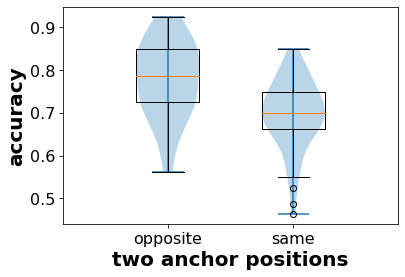

In [72]:
# plot the classification accuracy of anchors on opposite or on the same side of the medians of the two morphologies
nega = np.reshape(classification_result['%s' % (models[0])][-1][:, :, 0], (-1, 1))[np.where(np.reshape(sign_anchor_median, (-1, 1))==-1)[0]]
posi = np.reshape(classification_result['%s' % (models[0])][-1][:, :, 0], (-1, 1))[np.where(np.reshape(sign_anchor_median, (-1, 1))==1)[0]]
fig, ax= plt.subplots()
plt.violinplot([nega, posi], positions=[1, 1.6], widths=0.3)
plt.boxplot([nega, posi], notch=False, positions=[1, 1.6], widths=0.3)
ax.set_xticks(([1, 1.6]))
ax.set_xticklabels(['opposite', 'same'])
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'two anchor positions', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Text(0, 0.5, '|anchor to median|')

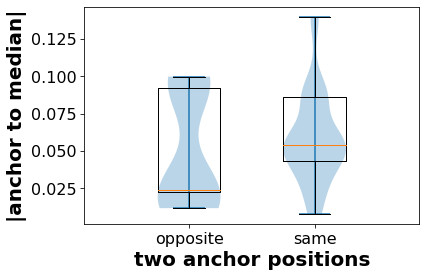

In [71]:
# plot the absolute distance of anchors to the medians of the two morphologies, whether on opposite sides or on the same sides.
nega = np.reshape(abs_dist_anchor_median, (-1, 1))[np.where(np.reshape(sign_anchor_median, (-1, 1))==-1)[0]]
posi = np.reshape(abs_dist_anchor_median, (-1, 1))[np.where(np.reshape(sign_anchor_median, (-1, 1))==1)[0]]
fig, ax= plt.subplots()
plt.violinplot([nega, posi], positions=[1, 1.6], widths=0.3)
plt.boxplot([nega, posi], notch=False, positions=[1, 1.6], widths=0.3)
ax.set_xticks(([1, 1.6]))
ax.set_xticklabels(['opposite', 'same'])
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'two anchor positions', fontsize=20, fontweight='bold')
ax.set_ylabel(r'|anchor to median|', fontsize=20, fontweight='bold')